# UGV obstacle aviodance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import re
import os
import glob

## Data making

**Reading txt files (and pad)**

In [2]:
pwm_left = list()
pwm_right = list()
srf_right = list()
srf_left = list()

max_length = 120

for FolderName in [name for name in os.listdir("./Data robot Modified") if os.path.isdir(os.path.join("./Data robot Modified", name))]:
   path = f'./Data robot Modified/{FolderName}'
   for filename in glob.glob(os.path.join(path, 'pwm_left.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         pwm_left.append(x)
   
   for filename in glob.glob(os.path.join(path, 'pwm_right.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         pwm_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'right_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         srf_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'left_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         srf_left.append(x)

pwm_left = [pwm_left[i][j] for i in range(len(pwm_left)) for j in range(len(pwm_left[i]))]
pwm_right = [pwm_right[i][j] for i in range(len(pwm_right)) for j in range(len(pwm_right[i]))]
srf_left = [srf_left[i][j] for i in range(len(srf_left)) for j in range(len(srf_left[i]))]
srf_right = [srf_right[i][j] for i in range(len(srf_right)) for j in range(len(srf_right[i]))]

controller_data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                                 'pwm right': np.array(pwm_right).reshape(-1,),
                                 'srf left': np.array(srf_left).reshape(-1,),
                                 'srf right': np.array(srf_right).reshape(-1,)})

**Reading txt files**

In [ ]:
pwm_left = list()
pwm_right = list()
srf_right = list()
srf_left = list()

for FolderName in [name for name in os.listdir("./Data robot Modified") if os.path.isdir(os.path.join("./Data robot Modified", name))]:
   path = f'./Data robot Modified/{FolderName}'
   for filename in glob.glob(os.path.join(path, 'pwm_left.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         pwm_left.append(x)
   
   for filename in glob.glob(os.path.join(path, 'pwm_right.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         pwm_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'right_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         srf_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'left_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         srf_left.append(x)
      
pwm_left = [pwm_left[i][j] for i in range(len(pwm_left)) for j in range(len(pwm_left[i]))]
pwm_right = [pwm_right[i][j] for i in range(len(pwm_right)) for j in range(len(pwm_right[i]))]
srf_left = [srf_left[i][j] for i in range(len(srf_left)) for j in range(len(srf_left[i]))]
srf_right = [srf_right[i][j] for i in range(len(srf_right)) for j in range(len(srf_right[i]))]

controller_data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                                 'pwm right': np.array(pwm_right).reshape(-1,),
                                 'srf left': np.array(srf_left).reshape(-1,),
                                 'srf right': np.array(srf_right).reshape(-1,)})

## Speed to position function

In [3]:
def position(pwm_right, pwm_left):
    r = 0.02
    L2 = 1
    max_speed = 100
    Ts = 0.1
    heading = 0
    w = 0
    x = [0]
    y = [0]
    v_right = np.array([i*max_speed*r/100. for i in pwm_right])
    v_left = np.array([i*max_speed*r/100. for i in pwm_left])

    v_x = (v_right + v_left)/2
    v_y = (v_right + v_left)/2
    w = v_left - v_right
    w = [i/L2 for i in w]
    for i in range(len(v_x)-1):
        v_x[i] = v_x[i]*(np.sin(heading))
        x.append(v_x[i]*Ts+x[i])
        v_y[i] = v_y[i]*(np.cos(heading))
        y.append(v_y[i]*Ts+y[i])
        heading = w[i]*Ts+heading

    plt.plot(x[0],y[0],'r*')
    plt.plot(x[1:],y[1:])
    plt.plot(x[len(x)-1],y[len(x)-1],'g*')

    return x, y

**proposed paths for training (with pad)**

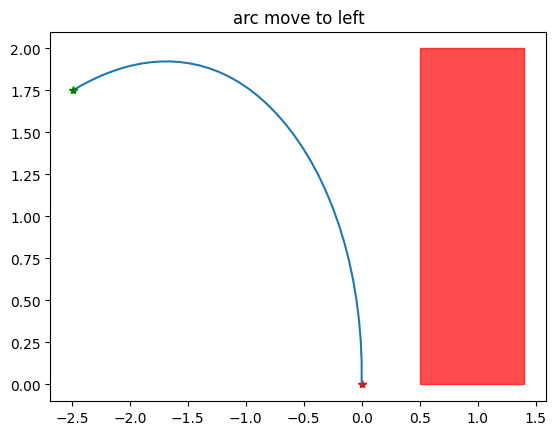

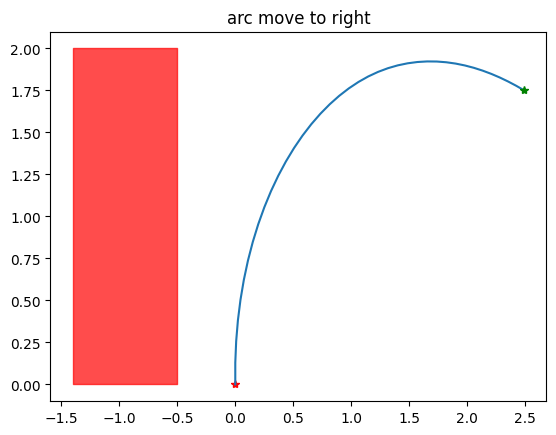

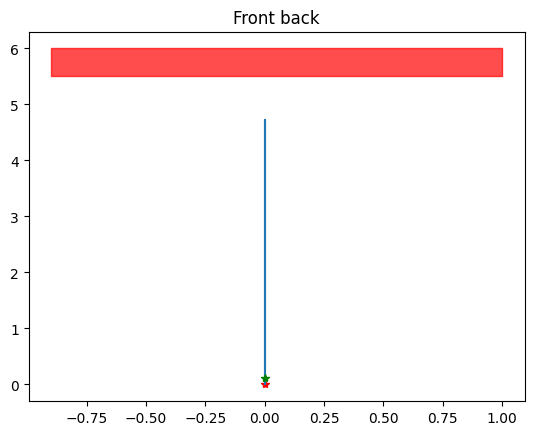

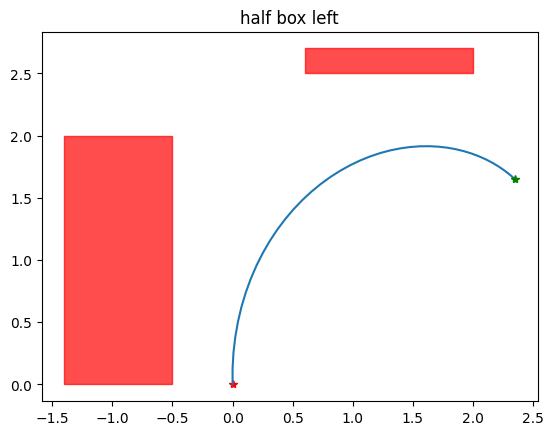

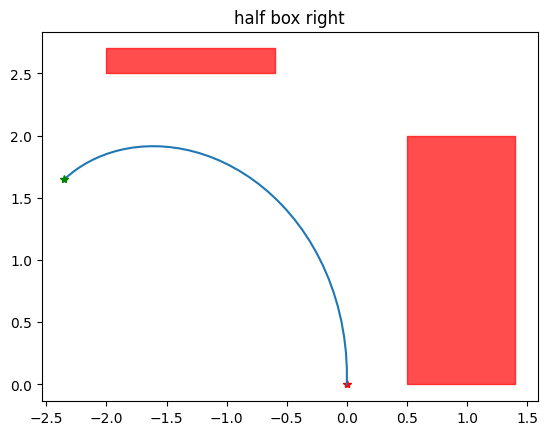

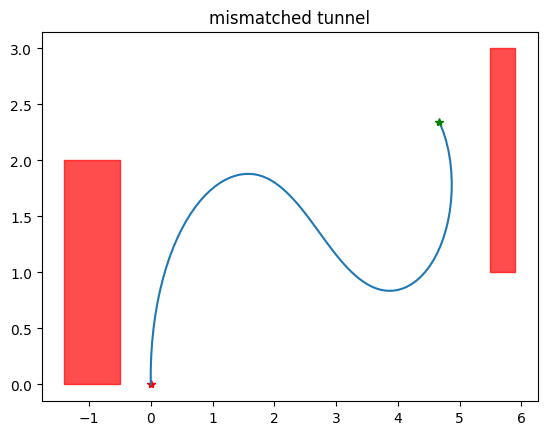

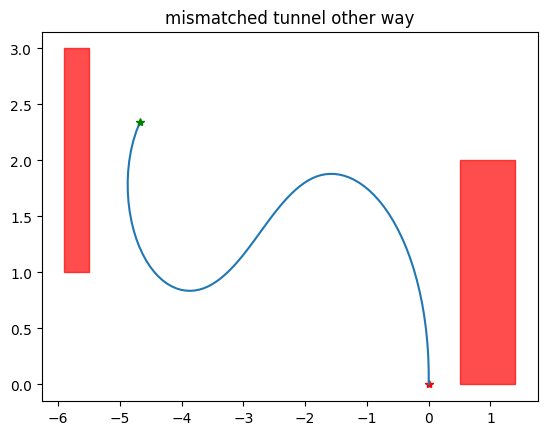

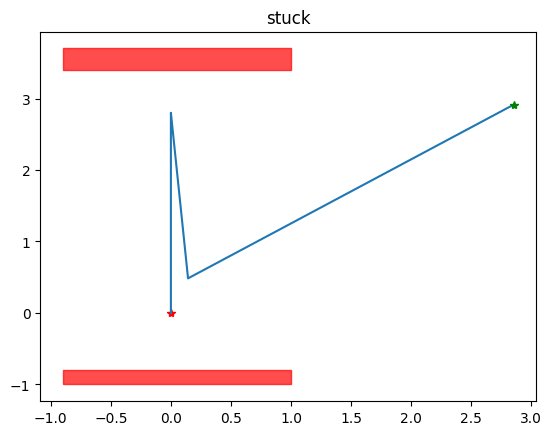

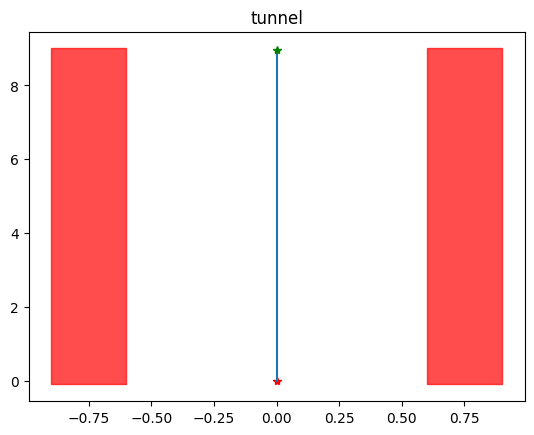

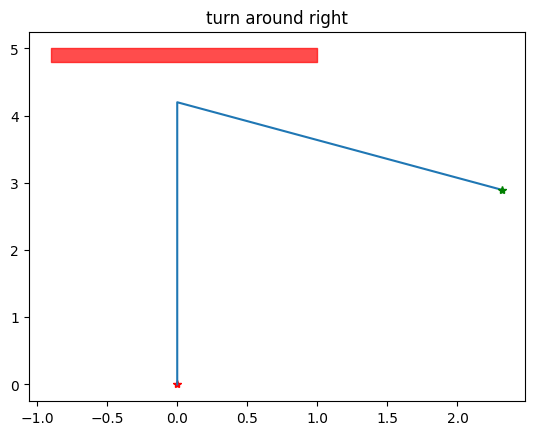

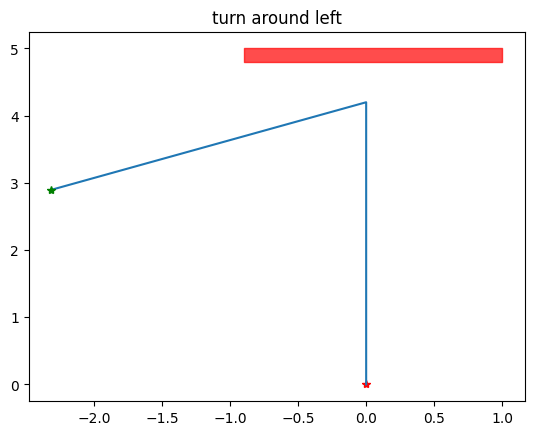

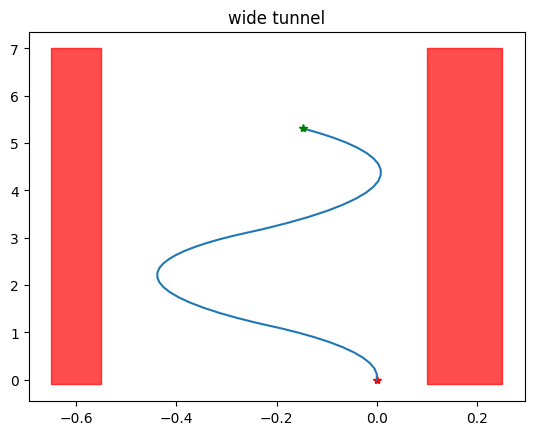

In [4]:
pos_x = list()
pos_y = list()

plt.title("arc move to left")
x,y = position(pwm_right[:120], pwm_left[:120])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("arc move to right")
x,y = position(pwm_right[120:240], pwm_left[120:240])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.5,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("Front back")
x,y = position(pwm_right[240:360], pwm_left[240:360])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 5.5, 6, color='red', alpha=0.7)
plt.show()

plt.title("half box left")
x,y = position(pwm_right[360:480], pwm_left[360:480])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.5,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(2.0,0.5,-0.1), 2.5, 2.7, color='red', alpha=0.7)
plt.show()

plt.title("half box right")
x,y = position(pwm_right[480:600], pwm_left[480:600])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(-2.0,-0.5,0.1), 2.5, 2.7, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel")
x,y = position(pwm_right[600:720], pwm_left[600:720])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.5,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(5.5,6,0.1), 1, 3, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel other way")
x,y = position(pwm_right[720:840], pwm_left[720:840])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(-5.5,-6,-0.1), 1, 3, color='red', alpha=0.7)
plt.show()

plt.title("stuck")
x,y = position(pwm_right[840:960], pwm_left[840:960])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 3.4, 3.7, color='red', alpha=0.7)
plt.fill_between(np.arange(1,-1,-0.1), -1, -0.8, color='red', alpha=0.7)
plt.show()

plt.title("tunnel")
x,y = position(pwm_right[960:1080], pwm_left[960:1080])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.6,1,0.1), -0.1, 9, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.6,-1,-0.1), -0.1, 9, color='red', alpha=0.7)
plt.show()

plt.title("turn around right")
x,y = position(pwm_right[1080:1200], pwm_left[1080:1200])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.8, 5, color='red', alpha=0.7)
plt.show()

plt.title("turn around left")
x,y = position(pwm_right[1200:1320], pwm_left[1200:1320])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.8, 5, color='red', alpha=0.7)
plt.show()

plt.title("wide tunnel")
x,y = position(pwm_right[1320:], pwm_left[1320:])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,0.3,0.05), -0.1, 7, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.55,-0.7,-0.05), -0.1, 7, color='red', alpha=0.7)
plt.show()

pos_x = np.array(sum(pos_x, []))
pos_y = np.array(sum(pos_y, []))

identification_data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                                    'pwm right': np.array(pwm_right).reshape(-1,),
                                    'x position': np.array(pos_x).reshape(-1,),
                                    'y position': np.array(pos_y).reshape(-1,)})

**proposed paths for training**

In [ ]:
pos_x = list()
pos_y = list()

plt.title("arc move to left")
x,y = position(pwm_right[:39], pwm_left[:39])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("arc move to right")
x,y = position(pwm_right[39:78], pwm_left[39:78])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("Front back")
x,y = position(pwm_right[78:197], pwm_left[78:197])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 5, 6, color='red', alpha=0.7)
plt.show()

plt.title("half box left")
x,y = position(pwm_right[197:236], pwm_left[197:236])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(2.0,0.1,-0.1), 2, 2.5, color='red', alpha=0.7)
plt.show()

plt.title("half box right")
x,y = position(pwm_right[236:276], pwm_left[236:276])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(-2.0,-0.1,0.1), 2, 2.5, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel")
x,y = position(pwm_right[276:365], pwm_left[276:365])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(5,6,0.1), 1, 3, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel other way")
x,y = position(pwm_right[365:454], pwm_left[365:454])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(-5,-6,-0.1), 1, 3, color='red', alpha=0.7)
plt.show()

plt.title("stuck")
x,y = position(pwm_right[454:549], pwm_left[454:549])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 3, 3.5, color='red', alpha=0.7)
plt.fill_between(np.arange(1,-1,-0.1), -1, -0.5, color='red', alpha=0.7)
plt.show()

plt.title("tunnel")
x,y = position(pwm_right[549:614], pwm_left[549:614])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1,0.1), -0.1, 9, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.5,-1,-0.1), -0.1, 9, color='red', alpha=0.7)
plt.show()

plt.title("turn around right")
x,y = position(pwm_right[614:679], pwm_left[614:679])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

plt.title("turn around left")
x,y = position(pwm_right[679:744], pwm_left[679:744])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

plt.title("wide tunnel")
x,y = position(pwm_right[744:], pwm_left[744:])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.05,0.3,0.05), -0.1, 7, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.45,-0.7,-0.05), -0.1, 7, color='red', alpha=0.7)
plt.show()

pos_x = np.array(sum(pos_x, []))
pos_y = np.array(sum(pos_y, []))

identification_data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                                    'pwm right': np.array(pwm_right).reshape(-1,),
                                    'x position': np.array(pos_x).reshape(-1,),
                                    'y position': np.array(pos_y).reshape(-1,)})

## Data preprocess

**Filtering**

In [5]:
def FirstOrder(x,dt=1,taw=9):
    a = dt/(dt + taw)
    y = [0 for i in range(len(x))]
    y[0] = x[0]
    for i in range(len(x)-1):
        y[i+1] = y[i] + a*(x[i+1] - x[i])
    return y

**Disturbance rejection**

In [6]:
def reject_dist(x_new,x_old):
    if (abs(x_new-x_old)>40):
        return x_old,x_old
    else:
        return x_old,x_new

**Normalize**

In [7]:
def feature_normalizer_std(x):
    scaler = StandardScaler()
    if isinstance(x,pd.Series):
        x = scaler.fit_transform(x.values.reshape((-1,1)))
    else:
        for i in x.columns:
            x[i] = scaler.fit_transform(x[i].values.reshape((-1,1)))
    return x

def feature_normalizer_minmax(x):
    scaler = MinMaxScaler()
    if isinstance(x,pd.Series):
        x = scaler.fit_transform(x.values.reshape((-1,1)))
    else:
        for i in x.columns:
            x[i] = scaler.fit_transform(x[i].values.reshape((-1,1)))
    return x

In [8]:
identification_data = feature_normalizer_std(identification_data)
identification_data.head(85)

,pwm left,pwm right,x position,y position
0,-0.688395,-0.675795,-0.019648,-0.771307
1,-0.688395,-0.675795,-0.019648,-0.771307
2,-0.688395,-0.675795,-0.019648,-0.771307
3,-0.688395,-0.675795,-0.019648,-0.771307
4,-0.688395,-0.675795,-0.019648,-0.771307
...,...,...,...,...
80,-0.688395,-0.675795,-0.019648,-0.771307
81,0.777618,1.641976,-0.019648,-0.771307
82,0.748298,1.613004,-0.019648,-0.690265
83,0.718978,1.584031,-0.026000,-0.610614


## Identifier using KERAS

**preprocessing batches and time series**

In [9]:
def split_sequences(sequences, n_steps):
# split a multivariate sequence into samples
	x, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-2], sequences[end_ix, -2:]
		x.append(seq_x)
		y.append(seq_y)
	return np.array(x), np.array(y)

def time_series_MLP(data, inseq1, inseq2, inseq3, inseq4, outseq1, outseq2, n_steps):
	# define input sequence
	# convert to [rows, columns] structure
	in_seq1 = np.array(data[[inseq1]]).reshape(-1, 1)
	in_seq2 = np.array(data[[inseq2]]).reshape(-1, 1)
	in_seq3 = np.array(data[[inseq3]]).reshape(-1, 1)
	in_seq4 = np.array(data[[inseq4]]).reshape(-1, 1)
	out_seq1 = np.array(data[[outseq1]]).reshape(-1, 1)
	out_seq2 = np.array(data[[outseq2]]).reshape(-1, 1)
	# horizontally stack columns
	data_set = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, out_seq1, out_seq2))
	x_train_seq, y_train_seq = split_sequences(data_set, n_steps)
	n_input = x_train_seq.shape[1] * x_train_seq.shape[2]
	n_output = y_train_seq.shape[1]
	# flatten input
	x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], n_input))

	return x_train_seq, y_train_seq, n_input, n_output

x_train_seq, y_train_seq, n_input, n_output = time_series_MLP(identification_data, "pwm left", "pwm right", "x position", "y position", "x position", "y position", 80)

**Network model**

In [10]:
model_NN = tf.keras.Sequential()
model_NN.add(tf.keras.layers.Input(n_input))
model_NN.add(tf.keras.layers.Dropout(0.15))
model_NN.add(tf.keras.layers.Dense(30,activation='tanh'))
model_NN.add(tf.keras.layers.Dropout(0.1))
model_NN.add(tf.keras.layers.Dense(n_output))

model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 30)                14430     
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 14,492
Trainable params: 14,492
Non-trainable params: 0
_________________________________________________________________


**Model fitting**

In [11]:
model_NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics='mae')
history = model_NN.fit(x_train_seq,y_train_seq,batch_size=4,validation_split=0.1,epochs=70)

Epoch 1/70
306/306 [==============================] - 2s 3ms/step - loss: 0.6077 - mae: 0.5854 - val_loss: 0.3388 - val_mae: 0.4229
Epoch 2/70
306/306 [==============================] - 1s 2ms/step - loss: 0.3093 - mae: 0.4212 - val_loss: 0.2554 - val_mae: 0.3469
Epoch 3/70
306/306 [==============================] - 1s 4ms/step - loss: 0.2449 - mae: 0.3648 - val_loss: 0.2394 - val_mae: 0.3673
Epoch 4/70
306/306 [==============================] - 1s 3ms/step - loss: 0.2151 - mae: 0.3404 - val_loss: 0.1190 - val_mae: 0.2421
Epoch 5/70
306/306 [==============================] - 1s 3ms/step - loss: 0.1787 - mae: 0.3055 - val_loss: 0.0924 - val_mae: 0.2011
Epoch 6/70
306/306 [==============================] - 1s 3ms/step - loss: 0.1675 - mae: 0.2884 - val_loss: 0.1293 - val_mae: 0.2594
Epoch 7/70
306/306 [==============================] - 1s 3ms/step - loss: 0.1543 - mae: 0.2752 - val_loss: 0.0780 - val_mae: 0.1826
Epoch 8/70
306/306 [==============================] - 1s 3ms/step - loss: 0.

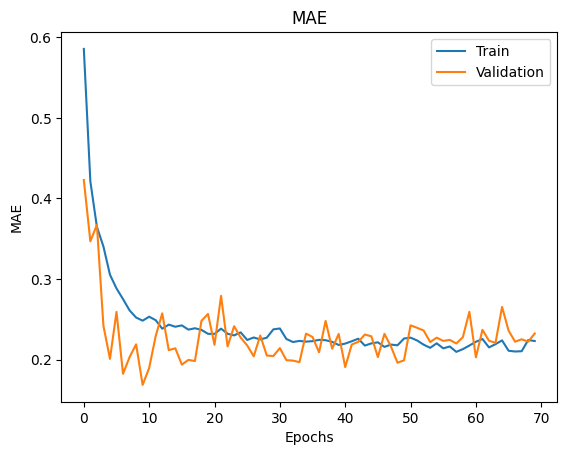

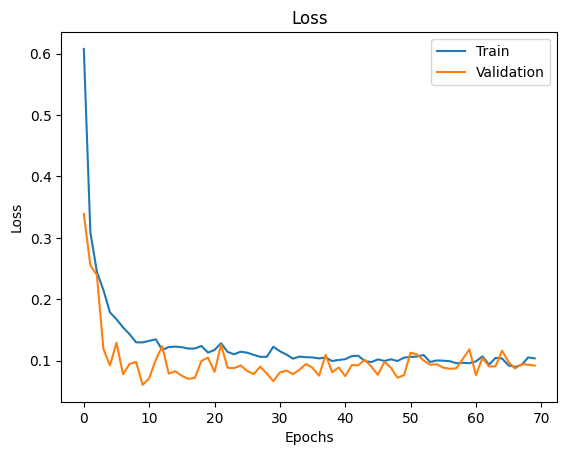

In [12]:
plt.figure()
plt.plot(history.history["mae"],label="Train")
plt.plot(history.history["val_mae"],label="Validation")
plt.title("MAE")
plt.ylabel("MAE")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(history.history["loss"],label="Train")
plt.plot(history.history["val_loss"],label="Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Evaluation and Test using a proposed map

**test path preparation**

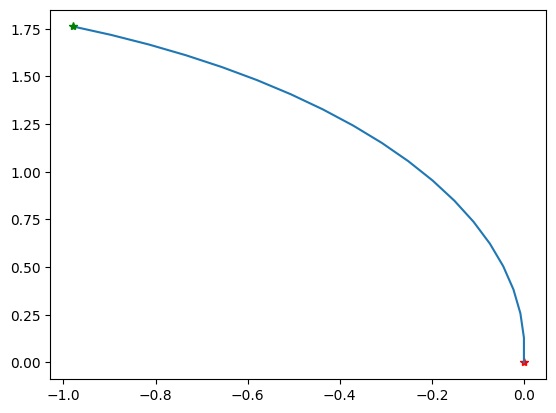

In [13]:
pwm_right1 = np.arange(80,60,-1)
pwm_left1 = np.arange(50,30,-1)

pwm_right = np.pad(pwm_right1, (max_length-len(pwm_right1),0), 'constant', constant_values=(0,))
pwm_left = np.pad(pwm_left1, (max_length-len(pwm_left1),0), 'constant', constant_values=(0,))
x,y= position(pwm_right, pwm_left)

test_data = pd.DataFrame({'pwm_left': np.array(pwm_left).reshape(-1,),
                          'pwm_right': np.array(pwm_right).reshape(-1,),
                          'x position': np.array(x).reshape(-1,),
                          'y position': np.array(y).reshape(-1,)})

test_data = feature_normalizer_std(test_data)

x_test, y_test, n_input, n_output = time_series_MLP(test_data, "pwm_left", "pwm_right", "x position", "y position", "x position", "y position", 80)

**testing on the path created**

2/2 [==============================] - 0s 3ms/step
mean squared error of the test 0.9590558742254324


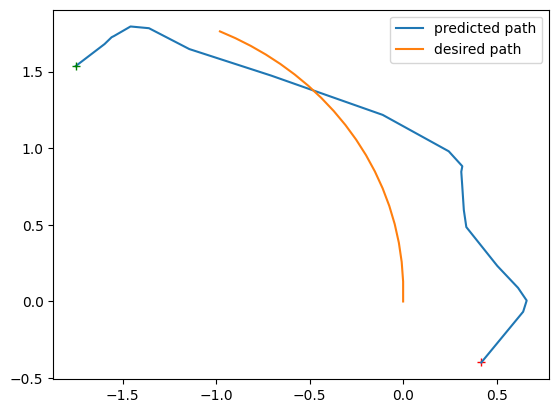

In [68]:
prediction = model_NN.predict(x_test)
print(f"mean squared error of the test {np.sqrt(mean_squared_error(y_test,prediction))}")
plt.plot(prediction[0,0],prediction[0,1],'r+')
plt.plot(prediction[:,0],prediction[:,1],label="predicted path")
plt.plot(prediction[-1:,0],prediction[-1:,1],'g+')
plt.plot(x,y,label="desired path")
plt.legend()
plt.show()

**Saving model and layer weights**

In [18]:
wights_NN = list()
for layer in model_NN.layers:
    wights_NN.append(layer.get_weights())
f = open("weights_NN.txt","w")
f.write(str(wights_NN))
f.close()

model_NN.save(filepath='ident_model.h5', include_optimizer=True)

## Controller using KERAS

**modifing dataset for LSTM**

In [5]:
LSTM_set = pd.DataFrame({
    "pwm left": [0.0],
    "pwm right": [0.0],
    "srf left": [0.0],
    "srf right": [0.0]},)

LSTM_set = LSTM_set.append(controller_data)
LSTM_set[['srf left','srf right']] = LSTM_set[['srf left','srf right']].shift(-1)
LSTM_set = LSTM_set.dropna(axis=0)
# LSTM_set = feature_normalizer_std(LSTM_set)
LSTM_set.head(85)

C:\Users\sinar\AppData\Local\Temp\ipykernel_8288\775278251.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LSTM_set = LSTM_set.append(controller_data)


,pwm left,pwm right,srf left,srf right
0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
...,...,...,...,...
79,0.0,0.0,0.0,0.0
80,0.0,0.0,244.0,52.0
81,50.0,80.0,289.0,50.0
82,49.0,79.0,274.0,50.0


In [6]:
# Put inputs into a single list
LSTM_set['single_input_vector'] = LSTM_set[['srf left','srf right','pwm left','pwm right']].apply(tuple, axis=1).apply(list)
# Double-encapsulate list so we can sum it in the next step and keep time steps as separate elements
LSTM_set['single_input_vector'] = LSTM_set.single_input_vector.apply(lambda x: [list(x)])
# Using .cumsum() to include previous row vectors in the current row list of vectors (creating time series)
LSTM_set['cumulative_input_vectors'] = LSTM_set.single_input_vector.cumsum()

LSTM_set['output_vector'] = LSTM_set[['pwm left','pwm right']].apply(tuple, axis=1).apply(list)


In [7]:
max_sequence_length = LSTM_set.cumulative_input_vectors.apply(len).max()
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(LSTM_set.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
LSTM_set['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)

LSTM_set.head(85)

,pwm left,pwm right,srf left,srf right,single_input_vector,cumulative_input_vectors,output_vector,padded_input_vectors
0,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0]]","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
0,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
1,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
2,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
3,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
...,...,...,...,...,...,...,...,...
79,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
80,0.0,0.0,244.0,52.0,"[[244.0, 52.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
81,50.0,80.0,289.0,50.0,"[[289.0, 50.0, 50.0, 80.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[50.0, 80.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."
82,49.0,79.0,274.0,50.0,"[[274.0, 50.0, 49.0, 79.0]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[49.0, 79.0]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,..."


In [8]:
x_train_init = np.asarray(LSTM_set.padded_input_vectors)

# Use hstack to and reshape to make the inputs a 3d vector
x_train = np.hstack(x_train_init).reshape(len(LSTM_set),max_sequence_length,4)
y_train = np.hstack(np.asarray(LSTM_set.output_vector)).reshape(len(LSTM_set),2)
print(x_train_init.shape)
print(x_train.shape)

# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
# Output dimensions is the shape of a single output vector
input_length = x_train.shape[1]
input_dim = x_train.shape[2]
output_dim = len(y_train[0])

(1440,)
(1440, 1440, 4)


**Network model**

In [9]:
model_control = tf.keras.Sequential()
model_control.add(tf.keras.layers.LSTM(100, input_dim = input_dim, input_length = input_length))
model_control.add(tf.keras.layers.Dense(output_dim))

model_control.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 42,202
Trainable params: 42,202
Non-trainable params: 0
_________________________________________________________________


**Model fitting**

In [10]:
model_control.compile(loss='mse',optimizer='sgd', metrics=['mae'])
history = model_control.fit(x_train, y_train, validation_split=0.1, batch_size=8, epochs=40, verbose = 1)

Epoch 1/40
162/162 [==============================] - 86s 520ms/step - loss: 485.8307 - mae: 13.0594 - val_loss: 320.7499 - val_mae: 8.8370
Epoch 2/40
162/162 [==============================] - 83s 514ms/step - loss: 348.0657 - mae: 10.6611 - val_loss: 362.7650 - val_mae: 9.8365
Epoch 3/40
162/162 [==============================] - 83s 515ms/step - loss: 305.2057 - mae: 10.0180 - val_loss: 366.2065 - val_mae: 10.5403
Epoch 4/40
162/162 [==============================] - 83s 512ms/step - loss: 279.0090 - mae: 9.6465 - val_loss: 346.0387 - val_mae: 10.5072
Epoch 5/40
162/162 [==============================] - 83s 512ms/step - loss: 260.7469 - mae: 9.5420 - val_loss: 322.4841 - val_mae: 9.6555
Epoch 6/40
162/162 [==============================] - 84s 518ms/step - loss: 241.4400 - mae: 9.1290 - val_loss: 311.4973 - val_mae: 9.4360
Epoch 7/40
162/162 [==============================] - 84s 521ms/step - loss: 217.2786 - mae: 8.5410 - val_loss: 318.9022 - val_mae: 9.4133
Epoch 8/40
162/162 [==

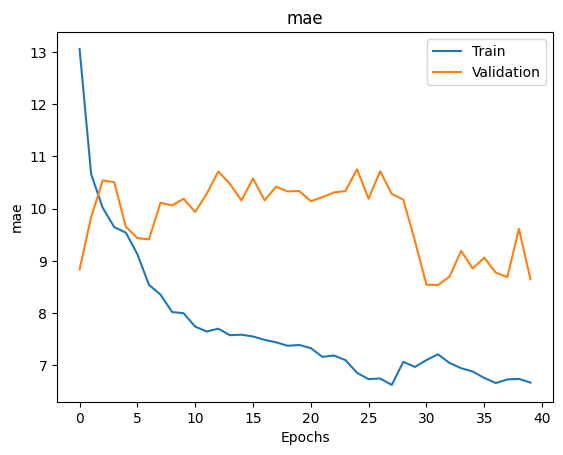

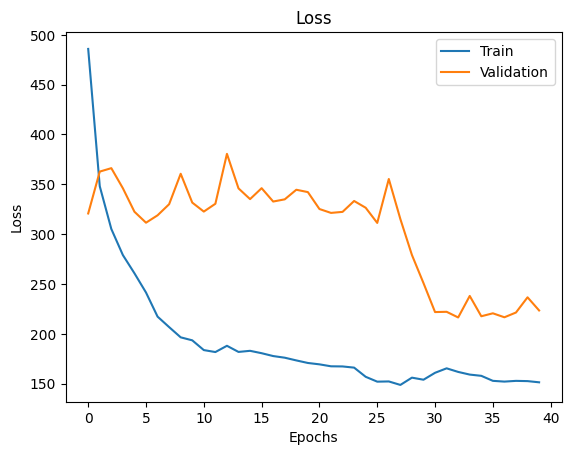

In [11]:
plt.figure()
plt.plot(history.history["mae"],label="Train")
plt.plot(history.history["val_mae"],label="Validation")
plt.title("mae")
plt.ylabel("mae")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(history.history["loss"],label="Train")
plt.plot(history.history["val_loss"],label="Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

**test path**

1/1 [==============================] - 0s 155ms/step
[[82.49504089 56.91604233]
 [55.43148041 67.74621582]
 [63.88366318 80.75605011]
 [55.43148041 67.74621582]
 [55.43148041 67.74621582]
 [64.85340118 82.24869537]
 [55.43148041 67.74621582]
 [64.85359955 82.24900055]
 [55.43148041 67.74621582]
 [64.85359955 82.24900055]
 [55.43148041 67.74621582]
 [64.85359955 82.24900055]
 [55.43148041 67.74621582]
 [64.84018707 82.22836304]
 [55.43147659 67.74622345]
 [64.85359955 82.24900055]
 [55.43147278 67.74623108]
 [64.85359955 82.24900055]
 [55.43058395 67.74756622]]


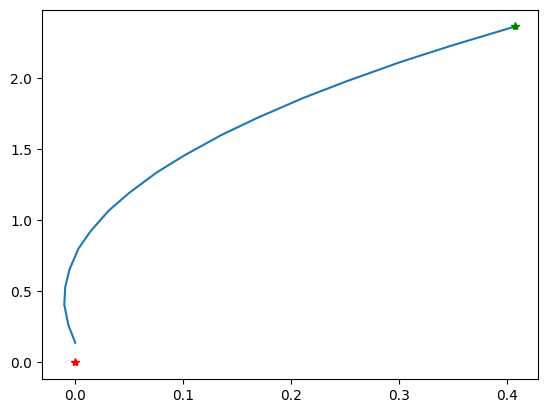

In [14]:
srf_left = np.arange(40,80,2)
srf_right = np.random.randint(200,250,len(srf_left))
pwm_right = np.array([0])
pwm_left = np.array([0])
predict = list()
test_set = pd.DataFrame({"pwm left": pwm_left.reshape(-1,),
                        "pwm right": pwm_right.reshape(-1,),
                        "srf left": srf_left[0].reshape(-1,),
                        "srf right": srf_right[0].reshape(-1,)})

for i in range(len(srf_left)-1):
    test_set = pd.DataFrame({"pwm left": pwm_left.reshape(-1,),
                            "pwm right": pwm_right.reshape(-1,),
                            "srf left": srf_left[i].reshape(-1,),
                            "srf right": srf_right[i].reshape(-1,)})
    test_set['single_input_vector'] = test_set[['srf left','srf right','pwm left','pwm right']].apply(tuple, axis=1).apply(list)
    test_set['single_input_vector'] = test_set.single_input_vector.apply(lambda x: [list(x)])
    test_set['cumulative_input_vectors'] = test_set.single_input_vector.cumsum()
    test_set['output_vector'] = test_set[['pwm left','pwm right']].apply(tuple, axis=1).apply(list)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_set.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
    test_set['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)

    x_test_init = np.asarray(test_set.padded_input_vectors)
    x_test = np.hstack(x_test_init).reshape(len(test_set),max_sequence_length,4)
    y_test = np.hstack(np.asarray(test_set.output_vector)).reshape(len(test_set),2)

    prediction = model_control.predict(x_test)
    pwm_right = np.array(prediction[0,1])
    pwm_left = np.array(prediction[0,0])
    predict.append(prediction.tolist())

predict = np.array(sum(predict, []))
print(predict)
x,y = position(predict[:,0], predict[:,1])

**Saving model and layer weights**

In [15]:
wights_contoller = list()
for layer in model_control.layers:
    wights_contoller.append(layer.get_weights())
f = open("weights_controller.txt","w")
f.write(str(wights_contoller))
f.close()

model_control.save(filepath='controller_model.h5', include_optimizer=True)

## Identifier using equations

In [ ]:
def NN_identifier_train(u, x, eta1=0.5, eta2=0.5, p1=0.5, p2=0.5, Ts=0.001):
    '''given u and x are column vectors'''
    w_hat = np.random.random((1,10))
    w_hat_last = np.zeros(w_hat.shape)
    v_hat = np.random.random((10,2))
    v_hat_last = np.zeros(v_hat.shape)
    # x_hat = np.zeros(x[:,0].reshape(-1,1).shape)
    x_hat = x[:,0].reshape(-1,1)
    x_hat_last = np.zeros(x_hat.shape)
    x_bar = np.concatenate((x[:,0],u[:,0]),axis=0).reshape(-1,1)
    # x_bar_hat = np.zeros(x_bar.shape)
    x_bar_hat = np.concatenate((x_hat[:,0],u[:,0]),axis=0).reshape(-1,1)

    x_bar_hat_last = np.zeros(x_bar_hat.shape)

    for i in range(x.shape[1]):
        x_bar = np.concatenate((x[:,i],u[:,i]),axis=0).reshape(-1,1)
        x_tild = x[:,i].reshape(-1,1) - x_hat
        A = -np.eye(1)

        w_hat = (-eta1*
                    np.matmul(
                        (np.matmul(x_tild.T,np.linalg.inv(A))).T 
                            , (sigmoid(np.matmul(v_hat,x_bar_hat_last))).T ) 
                                - p1*np.linalg.norm(x_tild,2)*w_hat_last)*Ts +  w_hat_last
        
        v_hat = (np.matmul(-eta2*
                            (np.matmul(
                                np.matmul(
                                    np.matmul(x_tild.T,np.linalg.inv(A)),w_hat)
                                        ,(np.eye(10) - landa(np.matmul(v_hat_last,x_bar_hat_last))))).T,x_bar_hat_last.T) - p2*np.linalg.norm(x_tild,2)*v_hat_last)*Ts + v_hat_last
        
        x_hat = (np.matmul(A,x_hat_last) 
                    + np.matmul(w_hat,
                        sigmoid(np.matmul(v_hat,x_bar_hat_last))))*Ts + x_hat_last

        x_bar_hat = np.concatenate((x_hat,u[:,i].reshape(-1,1)),axis=0)
        x_bar_hat_last = x_bar_hat
        w_hat_last = w_hat
        v_hat_last = v_hat
    return (w_hat,v_hat,x_hat)

In [ ]:
def NN_model(w, v, x, activation = 'sig'):
    first_layer = np.matmul(v,x)
    if activation == 'sig':
        first_layer = sigmoid(first_layer)
    output = np.matmul(w,first_layer)
    return output